<a href="https://colab.research.google.com/github/nishant42491/GAN_Art/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import torch
import torchvision
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import torchvision.models as models
from torch.utils.data import Dataset,DataLoader,random_split
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision.datasets.folder import default_loader
import matplotlib.pyplot as plt
%matplotlib inline


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
device='cuda'

In [4]:
!unzip gdrive/My\ Drive/Data_Gan/Best_Artworks.zip

Streaming output truncated to the last 5000 lines.
  inflating: Best_Artworks/resized/resized/Henri_Matisse_78.jpg  
  inflating: Best_Artworks/resized/resized/Henri_Matisse_79.jpg  
  inflating: Best_Artworks/resized/resized/Henri_Matisse_8.jpg  
  inflating: Best_Artworks/resized/resized/Henri_Matisse_80.jpg  
  inflating: Best_Artworks/resized/resized/Henri_Matisse_81.jpg  
  inflating: Best_Artworks/resized/resized/Henri_Matisse_82.jpg  
  inflating: Best_Artworks/resized/resized/Henri_Matisse_83.jpg  
  inflating: Best_Artworks/resized/resized/Henri_Matisse_84.jpg  
  inflating: Best_Artworks/resized/resized/Henri_Matisse_85.jpg  
  inflating: Best_Artworks/resized/resized/Henri_Matisse_86.jpg  
  inflating: Best_Artworks/resized/resized/Henri_Matisse_87.jpg  
  inflating: Best_Artworks/resized/resized/Henri_Matisse_88.jpg  
  inflating: Best_Artworks/resized/resized/Henri_Matisse_89.jpg  
  inflating: Best_Artworks/resized/resized/Henri_Matisse_9.jpg  
  inflating: Best_Artworks/

In [5]:
batch_size = 64
image_size = (64,64)
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [6]:
transform_ds = transforms.Compose([transforms.Resize(image_size),
                                  #transforms.RandomCrop(32, padding=2),
                                  transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   transforms.Normalize(*stats)
                                   ])

In [7]:
train_ds = torchvision.datasets.ImageFolder(root="/content/Best_Artworks/resized",transform=transform_ds)

In [8]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
print(len(train_ds))

8683


In [9]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [10]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(3, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [11]:
generator=generator.to(device)
discriminator=discriminator.to(device)

In [12]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()
    
    # Pass real images through discriminator
    real_preds = discriminator(real_images.to(device))
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds.to(device), real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, 3, 1, 1, device=device)
    fake_images = generator(latent.to(device))
    fake_images=fake_images.to(device)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [13]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, 3, 1, 1, device=device)
    fake_images = generator(latent.to(device))
    
    # Try to fool the discriminator
    preds = discriminator(fake_images.to(device))
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [14]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [15]:
fixed_latent = torch.randn(64, 3, 1, 1, device=device)

In [16]:
from tqdm.notebook import tqdm
import torch.nn.functional as F
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in tqdm(range(epochs)):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        
    
    return losses_g, losses_d, real_scores, fake_scores

In [17]:
lr = 0.003
epochs = 150

In [18]:
history = fit(epochs,lr)

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [1/150], loss_g: 5.9860, loss_d: 0.1601, real_score: 0.9580, fake_score: 0.0342


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [2/150], loss_g: 1.9177, loss_d: 0.7895, real_score: 0.6200, fake_score: 0.1553


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [3/150], loss_g: 2.3786, loss_d: 1.2154, real_score: 0.6195, fake_score: 0.4184


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [4/150], loss_g: 1.3462, loss_d: 1.1105, real_score: 0.4807, fake_score: 0.2084


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [5/150], loss_g: 5.2677, loss_d: 1.0025, real_score: 0.8933, fake_score: 0.5442


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [6/150], loss_g: 2.1532, loss_d: 0.6977, real_score: 0.6606, fake_score: 0.1508


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [7/150], loss_g: 3.4320, loss_d: 0.9818, real_score: 0.4665, fake_score: 0.0605


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [8/150], loss_g: 2.5005, loss_d: 1.2606, real_score: 0.5873, fake_score: 0.3040


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [9/150], loss_g: 3.2992, loss_d: 0.7259, real_score: 0.7324, fake_score: 0.2976


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [10/150], loss_g: 2.3193, loss_d: 1.2139, real_score: 0.8686, fake_score: 0.5819


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [11/150], loss_g: 3.1196, loss_d: 0.9974, real_score: 0.6396, fake_score: 0.2936


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [12/150], loss_g: 2.4265, loss_d: 1.2021, real_score: 0.5519, fake_score: 0.2015


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [13/150], loss_g: 1.9534, loss_d: 1.0961, real_score: 0.5347, fake_score: 0.1806


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [14/150], loss_g: 4.6673, loss_d: 0.8382, real_score: 0.8260, fake_score: 0.4176


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [15/150], loss_g: 2.6573, loss_d: 0.8260, real_score: 0.6177, fake_score: 0.2330


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [16/150], loss_g: 3.2376, loss_d: 0.8220, real_score: 0.5473, fake_score: 0.0879


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [17/150], loss_g: 2.4160, loss_d: 0.5822, real_score: 0.7153, fake_score: 0.1724


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [18/150], loss_g: 2.4341, loss_d: 1.1817, real_score: 0.5387, fake_score: 0.2890


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [19/150], loss_g: 3.1320, loss_d: 1.0283, real_score: 0.7476, fake_score: 0.4460


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [20/150], loss_g: 1.8238, loss_d: 1.4352, real_score: 0.4102, fake_score: 0.1436


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [21/150], loss_g: 1.9115, loss_d: 0.7133, real_score: 0.6651, fake_score: 0.2171


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [22/150], loss_g: 1.0436, loss_d: 1.8123, real_score: 0.5614, fake_score: 0.4742


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [23/150], loss_g: 3.6432, loss_d: 0.4098, real_score: 0.7976, fake_score: 0.0920


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [24/150], loss_g: 2.2346, loss_d: 0.7455, real_score: 0.7696, fake_score: 0.3341


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [25/150], loss_g: 2.2962, loss_d: 0.9416, real_score: 0.5344, fake_score: 0.1710


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [26/150], loss_g: 1.5812, loss_d: 0.8602, real_score: 0.6922, fake_score: 0.3232


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [27/150], loss_g: 2.9312, loss_d: 1.4200, real_score: 0.4610, fake_score: 0.2567


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [28/150], loss_g: 2.5299, loss_d: 0.7365, real_score: 0.6709, fake_score: 0.2261


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [29/150], loss_g: 2.5917, loss_d: 0.5385, real_score: 0.9662, fake_score: 0.3525


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [30/150], loss_g: 1.9747, loss_d: 0.9322, real_score: 0.6220, fake_score: 0.2779


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [31/150], loss_g: 3.8061, loss_d: 0.7550, real_score: 0.7322, fake_score: 0.2773


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [32/150], loss_g: 3.6693, loss_d: 0.9420, real_score: 0.9367, fake_score: 0.5092


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [33/150], loss_g: 3.0494, loss_d: 1.4314, real_score: 0.7293, fake_score: 0.5864


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [34/150], loss_g: 2.5811, loss_d: 0.9691, real_score: 0.6583, fake_score: 0.3634


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [35/150], loss_g: 2.8377, loss_d: 1.3848, real_score: 0.5842, fake_score: 0.4226


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [36/150], loss_g: 3.6698, loss_d: 0.9931, real_score: 0.8600, fake_score: 0.5020


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [37/150], loss_g: 2.5182, loss_d: 0.5795, real_score: 0.7369, fake_score: 0.1858


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [38/150], loss_g: 1.7410, loss_d: 1.1311, real_score: 0.4705, fake_score: 0.1579


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [39/150], loss_g: 1.8635, loss_d: 1.0368, real_score: 0.4532, fake_score: 0.0555


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [40/150], loss_g: 3.5765, loss_d: 0.6816, real_score: 0.6249, fake_score: 0.1043


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [41/150], loss_g: 3.2930, loss_d: 1.7194, real_score: 0.2827, fake_score: 0.1170


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [42/150], loss_g: 1.6725, loss_d: 1.4178, real_score: 0.3314, fake_score: 0.0538


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [43/150], loss_g: 6.4072, loss_d: 1.1063, real_score: 0.8493, fake_score: 0.5439


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [44/150], loss_g: 3.2863, loss_d: 0.7173, real_score: 0.8388, fake_score: 0.3388


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [45/150], loss_g: 3.1752, loss_d: 0.5265, real_score: 0.7521, fake_score: 0.1584


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [46/150], loss_g: 4.2089, loss_d: 0.4349, real_score: 0.7010, fake_score: 0.0258


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [47/150], loss_g: 4.3984, loss_d: 0.8966, real_score: 0.6627, fake_score: 0.2371


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [48/150], loss_g: 2.5026, loss_d: 1.3353, real_score: 0.4436, fake_score: 0.0206


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [49/150], loss_g: 4.5119, loss_d: 0.4304, real_score: 0.9792, fake_score: 0.2965


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [50/150], loss_g: 5.1976, loss_d: 0.4782, real_score: 0.7720, fake_score: 0.1359


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [51/150], loss_g: 1.8463, loss_d: 1.1492, real_score: 0.4278, fake_score: 0.0639


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [52/150], loss_g: 2.8459, loss_d: 0.0608, real_score: 0.9948, fake_score: 0.0527


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [53/150], loss_g: 5.7372, loss_d: 0.8067, real_score: 0.7959, fake_score: 0.3789


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [54/150], loss_g: 4.9383, loss_d: 0.6576, real_score: 0.7859, fake_score: 0.2332


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [55/150], loss_g: 5.1543, loss_d: 0.8561, real_score: 0.8329, fake_score: 0.3964


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [56/150], loss_g: 3.3426, loss_d: 0.2549, real_score: 0.8482, fake_score: 0.0570


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [57/150], loss_g: 7.3400, loss_d: 1.4196, real_score: 0.8928, fake_score: 0.5801


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [58/150], loss_g: 5.9710, loss_d: 0.9442, real_score: 0.9793, fake_score: 0.5690


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [59/150], loss_g: 3.8355, loss_d: 0.4227, real_score: 0.7520, fake_score: 0.0659


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [60/150], loss_g: 3.0453, loss_d: 0.5159, real_score: 0.7004, fake_score: 0.0404


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [61/150], loss_g: 7.6316, loss_d: 0.9247, real_score: 0.8257, fake_score: 0.4099


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [62/150], loss_g: 4.5330, loss_d: 0.3813, real_score: 0.7585, fake_score: 0.0064


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [63/150], loss_g: 6.5635, loss_d: 0.7251, real_score: 0.9831, fake_score: 0.4342


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [64/150], loss_g: 7.7586, loss_d: 0.2406, real_score: 0.8386, fake_score: 0.0059


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [65/150], loss_g: 3.5561, loss_d: 1.4057, real_score: 0.3985, fake_score: 0.0060


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [66/150], loss_g: 2.6039, loss_d: 0.3831, real_score: 0.7992, fake_score: 0.0812


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [67/150], loss_g: 4.0734, loss_d: 0.4515, real_score: 0.8574, fake_score: 0.1933


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [68/150], loss_g: 4.5636, loss_d: 0.2565, real_score: 0.9554, fake_score: 0.1584


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [69/150], loss_g: 3.0791, loss_d: 0.6799, real_score: 0.6587, fake_score: 0.0920


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [70/150], loss_g: 4.1643, loss_d: 0.4518, real_score: 0.8164, fake_score: 0.1539


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [71/150], loss_g: 5.1035, loss_d: 0.2262, real_score: 0.9529, fake_score: 0.1463


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [72/150], loss_g: 4.9159, loss_d: 0.2490, real_score: 0.8547, fake_score: 0.0426


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [73/150], loss_g: 4.1820, loss_d: 0.4627, real_score: 0.7318, fake_score: 0.0378


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [74/150], loss_g: 1.9826, loss_d: 2.1802, real_score: 0.2824, fake_score: 0.0089


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [75/150], loss_g: 7.1714, loss_d: 1.1456, real_score: 0.9506, fake_score: 0.5429


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [76/150], loss_g: 2.5132, loss_d: 0.5001, real_score: 0.7142, fake_score: 0.0500


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [77/150], loss_g: 7.6323, loss_d: 0.6210, real_score: 0.9648, fake_score: 0.3671


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [78/150], loss_g: 7.5882, loss_d: 0.8455, real_score: 0.9319, fake_score: 0.4224


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [79/150], loss_g: 5.1475, loss_d: 0.4848, real_score: 0.8734, fake_score: 0.2058


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [80/150], loss_g: 3.1758, loss_d: 0.3423, real_score: 0.8812, fake_score: 0.1604


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [81/150], loss_g: 6.5133, loss_d: 0.3840, real_score: 0.9524, fake_score: 0.2404


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [82/150], loss_g: 7.4160, loss_d: 0.7518, real_score: 0.6509, fake_score: 0.0117


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [83/150], loss_g: 4.0776, loss_d: 0.4117, real_score: 0.7832, fake_score: 0.0856


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [84/150], loss_g: 2.4875, loss_d: 0.2131, real_score: 0.8972, fake_score: 0.0654


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [85/150], loss_g: 5.1861, loss_d: 0.2363, real_score: 0.9582, fake_score: 0.1581


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [86/150], loss_g: 4.9179, loss_d: 0.3463, real_score: 0.7860, fake_score: 0.0383


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [87/150], loss_g: 2.8815, loss_d: 0.1890, real_score: 0.9761, fake_score: 0.1330


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [88/150], loss_g: 3.3585, loss_d: 0.3781, real_score: 0.8910, fake_score: 0.1645


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [89/150], loss_g: 5.2923, loss_d: 0.1463, real_score: 0.9249, fake_score: 0.0567


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [90/150], loss_g: 6.5493, loss_d: 0.4275, real_score: 0.9594, fake_score: 0.2634


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [91/150], loss_g: 4.4001, loss_d: 0.7066, real_score: 0.6199, fake_score: 0.0233


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [92/150], loss_g: 1.9337, loss_d: 0.6026, real_score: 0.7108, fake_score: 0.0531


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [93/150], loss_g: 3.5129, loss_d: 0.2887, real_score: 0.9358, fake_score: 0.1668


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [94/150], loss_g: 16.5813, loss_d: 1.9280, real_score: 0.9998, fake_score: 0.7409


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [95/150], loss_g: 7.6878, loss_d: 0.5490, real_score: 0.9014, fake_score: 0.2755


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [96/150], loss_g: 2.1345, loss_d: 0.9548, real_score: 0.5831, fake_score: 0.1715


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [97/150], loss_g: 3.3030, loss_d: 0.6222, real_score: 0.6589, fake_score: 0.0621


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [98/150], loss_g: 3.7473, loss_d: 0.5710, real_score: 0.7684, fake_score: 0.1556


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [99/150], loss_g: 5.3868, loss_d: 0.1206, real_score: 0.9292, fake_score: 0.0391


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [100/150], loss_g: 5.1498, loss_d: 0.7001, real_score: 0.6788, fake_score: 0.0176


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [101/150], loss_g: 6.4193, loss_d: 0.0935, real_score: 0.9820, fake_score: 0.0650


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [102/150], loss_g: 3.8494, loss_d: 0.3294, real_score: 0.8221, fake_score: 0.0760


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [103/150], loss_g: 4.7424, loss_d: 0.2705, real_score: 0.8817, fake_score: 0.0311


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [104/150], loss_g: 9.5277, loss_d: 0.3288, real_score: 0.8003, fake_score: 0.0009


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [105/150], loss_g: 1.9298, loss_d: 0.7368, real_score: 0.6080, fake_score: 0.0374


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [106/150], loss_g: 6.2039, loss_d: 0.2641, real_score: 0.9039, fake_score: 0.0915


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [107/150], loss_g: 5.6968, loss_d: 0.3240, real_score: 0.9568, fake_score: 0.1824


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [108/150], loss_g: 1.8075, loss_d: 1.9660, real_score: 0.3428, fake_score: 0.0184


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [109/150], loss_g: 5.4023, loss_d: 0.2467, real_score: 0.8168, fake_score: 0.0084


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [110/150], loss_g: 4.6328, loss_d: 0.7767, real_score: 0.6038, fake_score: 0.0150


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [111/150], loss_g: 4.2314, loss_d: 0.4700, real_score: 0.8306, fake_score: 0.1239


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [112/150], loss_g: 5.0507, loss_d: 0.3745, real_score: 0.8614, fake_score: 0.1035


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [113/150], loss_g: 7.7118, loss_d: 0.4172, real_score: 0.9984, fake_score: 0.2578


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [114/150], loss_g: 5.7016, loss_d: 0.4314, real_score: 0.7675, fake_score: 0.0041


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [115/150], loss_g: 8.8552, loss_d: 0.7922, real_score: 0.9643, fake_score: 0.3298


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [116/150], loss_g: 8.7725, loss_d: 0.2119, real_score: 0.8608, fake_score: 0.0149


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [117/150], loss_g: 4.4954, loss_d: 0.3328, real_score: 0.8899, fake_score: 0.1375


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [118/150], loss_g: 7.1495, loss_d: 0.6957, real_score: 0.9972, fake_score: 0.3371


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [119/150], loss_g: 3.8109, loss_d: 0.4598, real_score: 0.9118, fake_score: 0.1942


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [120/150], loss_g: 2.1650, loss_d: 0.5768, real_score: 0.6946, fake_score: 0.0136


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [121/150], loss_g: 6.8173, loss_d: 0.4719, real_score: 0.8951, fake_score: 0.1748


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [122/150], loss_g: 4.8520, loss_d: 0.3339, real_score: 0.9191, fake_score: 0.1200


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [123/150], loss_g: 8.2568, loss_d: 0.6828, real_score: 0.9891, fake_score: 0.3947


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [124/150], loss_g: 3.6198, loss_d: 0.3794, real_score: 0.7730, fake_score: 0.0182


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [125/150], loss_g: 6.5010, loss_d: 0.0513, real_score: 0.9868, fake_score: 0.0334


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [126/150], loss_g: 5.2183, loss_d: 0.3320, real_score: 0.9181, fake_score: 0.1413


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [127/150], loss_g: 6.9405, loss_d: 0.2661, real_score: 0.8443, fake_score: 0.0014


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [128/150], loss_g: 3.8625, loss_d: 0.7172, real_score: 0.6627, fake_score: 0.1021


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [129/150], loss_g: 8.4370, loss_d: 0.3327, real_score: 0.7914, fake_score: 0.0064


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [130/150], loss_g: 4.3230, loss_d: 0.1974, real_score: 0.9998, fake_score: 0.0848


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [131/150], loss_g: 4.0050, loss_d: 0.9434, real_score: 0.6325, fake_score: 0.0039


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [132/150], loss_g: 4.3086, loss_d: 0.2211, real_score: 0.8711, fake_score: 0.0263


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [133/150], loss_g: 3.4342, loss_d: 0.5107, real_score: 0.7529, fake_score: 0.0950


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [134/150], loss_g: 7.9704, loss_d: 0.2593, real_score: 0.8502, fake_score: 0.0382


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [135/150], loss_g: 6.0078, loss_d: 0.1971, real_score: 0.9781, fake_score: 0.1392


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [136/150], loss_g: 2.6755, loss_d: 0.5229, real_score: 0.7028, fake_score: 0.0392


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [137/150], loss_g: 3.9556, loss_d: 0.1527, real_score: 0.9043, fake_score: 0.0361


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [138/150], loss_g: 1.9979, loss_d: 0.3984, real_score: 0.7830, fake_score: 0.0484


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [139/150], loss_g: 6.0610, loss_d: 0.1183, real_score: 0.9556, fake_score: 0.0606


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [140/150], loss_g: 10.2316, loss_d: 0.6392, real_score: 0.9956, fake_score: 0.3825


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [141/150], loss_g: 6.7390, loss_d: 0.2754, real_score: 0.9535, fake_score: 0.1029


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [142/150], loss_g: 6.6779, loss_d: 0.3975, real_score: 0.9426, fake_score: 0.2448


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [143/150], loss_g: 7.8148, loss_d: 0.3145, real_score: 0.9848, fake_score: 0.2154


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [144/150], loss_g: 6.8212, loss_d: 0.1522, real_score: 0.9256, fake_score: 0.0362


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [145/150], loss_g: 6.9496, loss_d: 0.2420, real_score: 0.8730, fake_score: 0.0745


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [146/150], loss_g: 3.1470, loss_d: 0.6639, real_score: 0.7227, fake_score: 0.1596


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [147/150], loss_g: 4.0120, loss_d: 0.2556, real_score: 0.8898, fake_score: 0.0504


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [148/150], loss_g: 4.4033, loss_d: 0.3193, real_score: 0.8675, fake_score: 0.1264


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [149/150], loss_g: 8.7148, loss_d: 0.4971, real_score: 0.9700, fake_score: 0.2595


  0%|          | 0/136 [00:00<?, ?it/s]

Epoch [150/150], loss_g: 11.5531, loss_d: 0.9746, real_score: 0.9973, fake_score: 0.4897


In [19]:
def denorm(img_tensors):
  return img_tensors * stats[1][0] + stats[0][0]
def show_images(images, nmax=64):
  fig, ax = plt.subplots(figsize=(8, 8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

In [20]:
a=torch.randn([64,3,1,1])
with torch.no_grad():
  a=generator(a.to(device))

a=a.detach()
a=a.to('cpu')

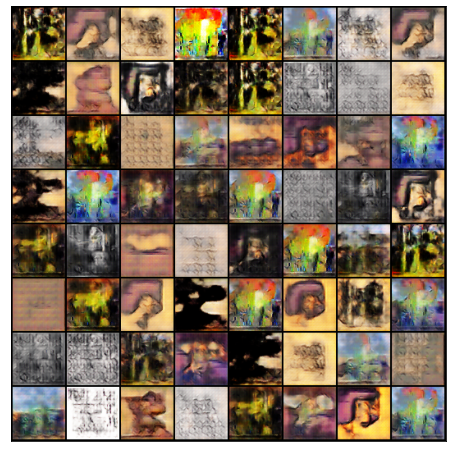

In [21]:
show_images(a)

In [22]:
torch.save(generator.state_dict(), "generator_wieghts_1")

In [23]:
torch.save(discriminator.state_dict(), "discriminator_wieghts_1")